In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import joblib
import re


In [42]:
data = pd.read_csv('new_user_measurements.csv')

# Convert height to centimeters
def convert_height(height):
    # Remove any non-numeric characters except feet and inches symbols
    clean_height = re.sub(r'[^0-9\'"]+', '', height)
    
    # Split based on the foot (') symbol
    if "'" in clean_height:
        feet, inches = clean_height.split("'")
        feet = int(feet)
        inches = int(inches.replace('"', '')) if inches else 0
    else:
        # Handle cases where height is only in inches
        feet, inches = 0, int(clean_height.replace('"', ''))
    
    return feet * 30.48 + inches * 2.54

data['Height'] = data['Height'].apply(convert_height)

In [89]:

# Encode categorical variables
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
data['Cup Size'] = LabelEncoder().fit_transform(data['Cup Size'])

# Fill missing values
imputer = SimpleImputer(strategy='mean')
data[['Bust/Chest', 'Cup Size', 'Waist', 'Hips', 'Body Shape Index']] = imputer.fit_transform(data[['Bust/Chest', 'Cup Size', 'Waist', 'Hips', 'Body Shape Index']])

# Feature selection
X = data[['Gender', 'Height', 'Weight', 'Bust/Chest', 'Cup Size', 'Waist', 'Hips', 'Body Shape Index']]

# # # Manually create the 'Size' label (this is an example)
# size_labels = ['XS','S', 'M', 'L', 'XL', 'XXL']  # Example size categories
# y = pd.cut(data['Bust/Chest'], bins=[0, 30, 32, 36, 40, 42, np.inf], labels=size_labels)

# Define the size assignment function
def assign_size(gender, bust_chest, cup_size=None):
    size_labels = ['XS', 'S', 'M', 'L', 'XL', 'XXL']
    
    if gender == 'Female':
        # Define size categories based on Bust Size and Cup Size
        if bust_chest < 32:
            if cup_size in ['A', 'B']:
                return 'XS'
            else:
                return 'S'
        elif bust_chest < 34:
            if cup_size in ['A', 'B']:
                return 'S'
            else:
                return 'M'
        elif bust_chest < 36:
            if cup_size in ['A', 'B']:
                return 'M'
            else:
                return 'L'
        elif bust_chest < 38:
            if cup_size in ['A', 'B']:
                return 'L'
            else:
                return 'XL'
        elif bust_chest < 40:
            if cup_size in ['A', 'B']:
                return 'XL'
            else:
                return 'XXL'
        else:
            return 'XXL'
    elif gender == 'Male':
        # Define size categories based on Bust Size only
        if bust_chest < 34:
            return 'XS'
        elif bust_chest < 36:
            return 'S'
        elif bust_chest < 38:
            return 'M'
        elif bust_chest < 40:
            return 'L'
        elif bust_chest < 42:
            return 'XL'
        else:
            return 'XXL'
    else:
        return 'Unknown'

# Apply the size assignment function
data['Size'] = data.apply(lambda row: assign_size(row['Gender'], row['Bust/Chest'], row.get('CupSize')), axis=1)

y = data['Size']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, 'clothing_size_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['clothing_size_model.pkl']

In [97]:
# Predict function
def predict_size(new_data):
    new_data = scaler.transform([new_data])
    return model.predict(new_data)[0]

# Model validation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy}')

# Example prediction
new_user_measurements = [1, 167, 67, 37, 3, 35, 38, 4]  # Replace with actual data
predicted_size = predict_size(new_user_measurements)
print(f'Predicted Size: {predicted_size}')

Model Accuracy: 0.95
Predicted Size: XXL


In [95]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Model accuracy: {accuracy:.2f}')


Model accuracy: 0.95


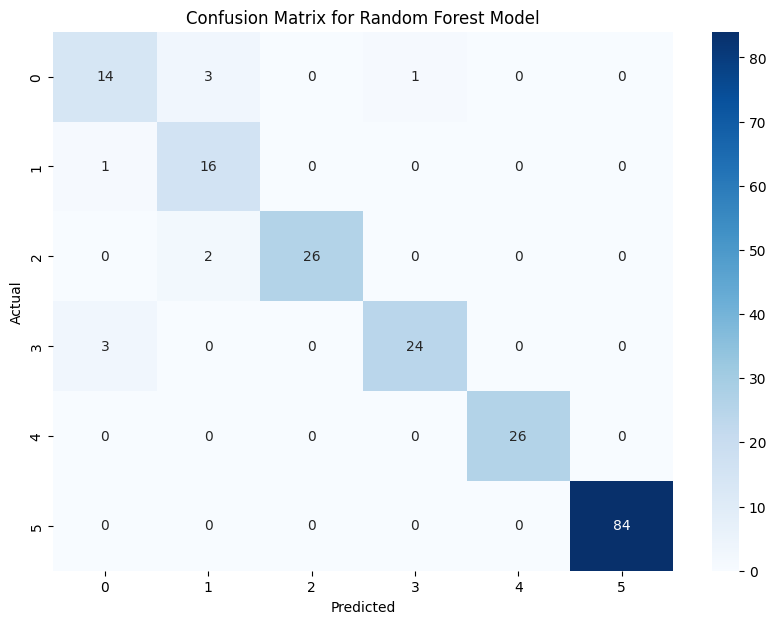

c:\Users\tashv\OneDrive\Desktop\GRID\sklearn-env\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\tashv\OneDrive\Desktop\GRID\sklearn-env\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\tashv\OneDrive\Desktop\GRID\sklearn-env\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\tashv\OneDrive\Desktop\GRID\sklearn-env\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


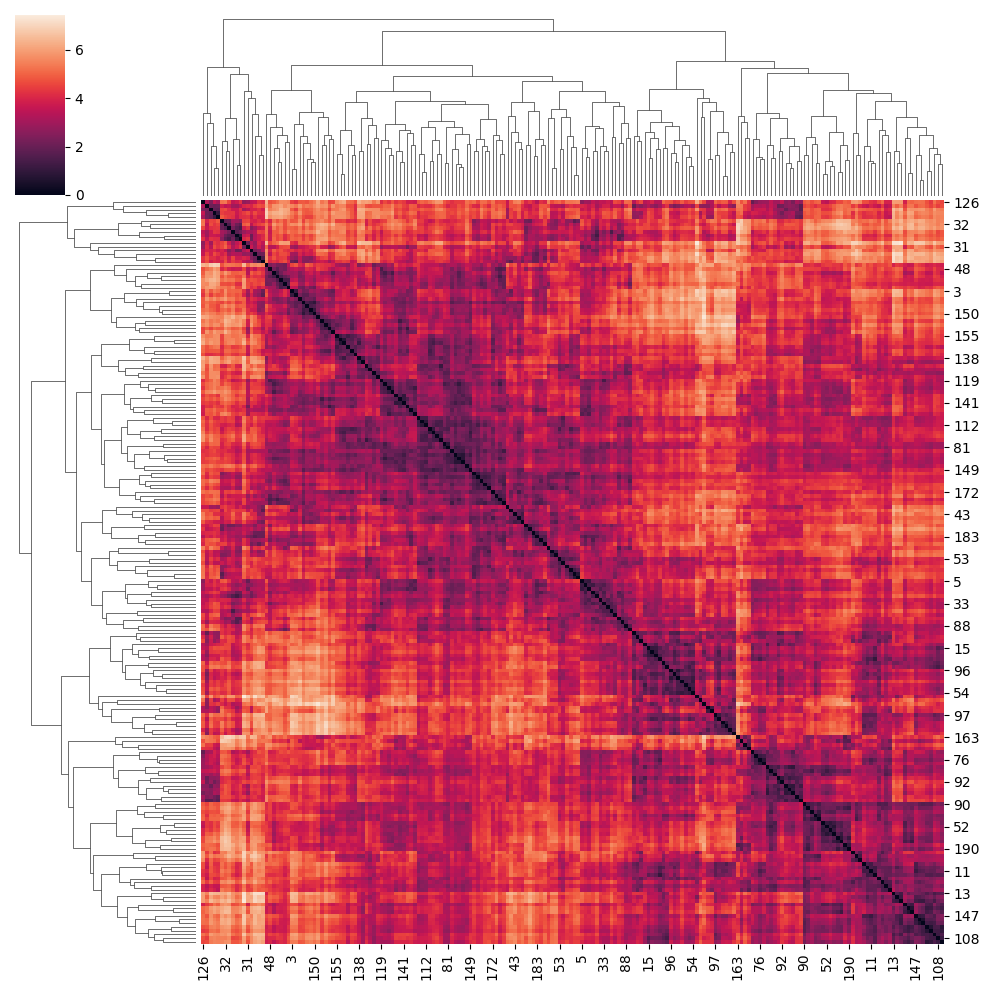

In [98]:
# plot a confusion matrix
# For study and explanation purposes and model performance evaluation

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Plot a cluster map

from sklearn.metrics import pairwise_distances

distances = pairwise_distances(X_test)
sns.clustermap(distances)
plt.show()
